# Gradient Boosted Decision Trees


https://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting  
https://towardsdatascience.com/machine-learning-part-18-boosting-algorithms-gradient-boosting-in-python-ef5ae6965be4  

In [1]:
# needs scikit-learn version >= 0.22 because of permutation_importance

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

from features import categorical_features, cols_idxs
from scores import save_score

## Read the data

In [2]:
df = pd.read_csv(os.path.join("data", "processed", "all_data2.csv"))
df.set_index("commune_id", inplace=True)
df.drop(columns=["name"], inplace=True)
vote_share_cols = [col for col in df.columns if col.startswith("vote_share_")]
df.drop(columns=vote_share_cols, inplace=True)

## Train/test split

In [3]:
# split the data into training (80%) and test (20%) sets
# we use stratification on the commune typology, which means that the proportions of the
# different typologies will be maintained in both sets (e.g. urban/rural)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=0, stratify=df["typology"])
X_train = df_train.drop(columns="po_value").values
y_train = df_train["po_value"].values
X_test = df_test.drop(columns="po_value").values
y_test = df_test["po_value"].values

# numerical indexes for categorical features, will be needed in preprocessor later
categorical_idxs = cols_idxs(df.drop(columns="po_value"), categorical_features)

## First run (default parameters)

learning_rate =  0.1  
n_estimators = 100  
max_depth = 3  
min_samples_split = 2

In [76]:
preprocessor = make_column_transformer(
    (OneHotEncoder(dtype=np.float64), categorical_idxs),
    remainder = "passthrough"
)

gtbr = make_pipeline(preprocessor, GradientBoostingRegressor(random_state=0))
gtbr.fit(X_train, y_train)
gtbr_test_pred = gtbr.predict(X_test)
print("With default params:")
print("GTBR MAE = {:.3f}".format(mean_absolute_error(y_test, gtbr_test_pred)))
print("GTBR R^2 = {:.3f}".format(gtbr.score(X_test, y_test)))

With default params:
GTBR MAE = 0.156
GTBR R^2 = 0.742


With default parameters, the model already performs almost as good as the best linear regression model (MAE = 0.153, $R^2$ = 0.749).

## Second run (tune learning_rate, n_estimators)

In [5]:
parameters = {
    "gradientboostingregressor__learning_rate": [0.08, 0.09, 0.1, 0.11, 0.12 ],
    "gradientboostingregressor__n_estimators": np.linspace(100, 800, 8, dtype=int)
}
gcv_gtbr = GridSearchCV(gtbr, parameters, scoring = "neg_mean_absolute_error", cv = 5, n_jobs=12, return_train_score=True)
gcv_gtbr.fit(X_train, y_train)
print("Grid search / cross-validation:")
print("Best params = {}".format(gcv_gtbr.best_params_))
print("Best MAE = {:.3f}".format(-gcv_gtbr.best_score_))
best_learning_rate = gcv_gtbr.best_params_["gradientboostingregressor__learning_rate"]
best_n_estimators = gcv_gtbr.best_params_["gradientboostingregressor__n_estimators"]

Grid search / cross-validation:
Best params = {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__n_estimators': 700}
Best MAE = 0.153


In [6]:
gcv_gtbr_test_pred = gcv_gtbr.predict(X_test)
gcv_gtbr_test_mae = mean_absolute_error(y_test, gcv_gtbr_test_pred)
gcv_gtbr_test_r2 = r2_score(y_test, gcv_gtbr_test_pred)
print("On test data:")
print("Tuned GTBR MAE = {:.3f}".format(gcv_gtbr_test_mae))
print("Tuned GTBR R^2 = {:.3f}".format(gcv_gtbr_test_r2))

On test data:
Tuned GTBR MAE = 0.151
Tuned GTBR R^2 = 0.756


### Cross validation ranking

In [7]:
df_gcv_gtbr = pd.DataFrame(gcv_gtbr.cv_results_)[
    ['rank_test_score', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score',
     'param_gradientboostingregressor__learning_rate', 'param_gradientboostingregressor__n_estimators']
    ].sort_values(by='rank_test_score')
df_gcv_gtbr.head()

,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score,param_gradientboostingregressor__learning_rate,param_gradientboostingregressor__n_estimators
22,1,-0.032000,0.000554,-0.153314,0.005275,0.1,700
23,2,-0.026568,0.000506,-0.153473,0.005428,0.1,800
12,3,-0.052366,0.001523,-0.153565,0.003716,0.09,500
13,4,-0.043658,0.001252,-0.153566,0.004282,0.09,600
21,5,-0.038796,0.000611,-0.153629,0.004761,0.1,600


## Third run (tune max_depth, min_samples_split)

In [8]:
parameters2 = {
    "gradientboostingregressor__learning_rate": [best_learning_rate],
    "gradientboostingregressor__n_estimators": [best_n_estimators],
    "gradientboostingregressor__max_depth": np.linspace(1, 10, 10),
    "gradientboostingregressor__min_samples_split": np.linspace(2, 10, 9, dtype=int)
}
gcv2_gtbr = GridSearchCV(gtbr, parameters2, scoring = "neg_mean_absolute_error", cv = 5, n_jobs=12, return_train_score=True)
gcv2_gtbr.fit(X_train, y_train)
print("Grid search / cross-validation:")
print("Best params = {}".format(gcv2_gtbr.best_params_))
print("Best MAE = {:.3f}".format(-gcv2_gtbr.best_score_))
best_max_depth = gcv2_gtbr.best_params_["gradientboostingregressor__max_depth"]
best_min_samples_split = gcv2_gtbr.best_params_["gradientboostingregressor__min_samples_split"]

Grid search / cross-validation:
Best params = {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 3.0, 'gradientboostingregressor__min_samples_split': 7, 'gradientboostingregressor__n_estimators': 700}
Best MAE = 0.152


In [10]:
gcv2_gtbr_test_pred = gcv2_gtbr.predict(X_test)
gcv2__gtbr_test_mae = mean_absolute_error(y_test, gcv2_gtbr_test_pred)
gcv2_gtbr_test_r2 = r2_score(y_test, gcv2_gtbr_test_pred)
print("On test data:")
print("Tuned GTBR MAE = {:.3f}".format(gcv2__gtbr_test_mae))
print("Tuned GTBR R^2 = {:.3f}".format(gcv2_gtbr_test_r2))
save_score("gtbr", gcv2__gtbr_test_mae, gcv2_gtbr_test_r2, os.path.join("data", "results", "model_scores.csv"))

On test data:
Tuned GTBR MAE = 0.153
Tuned GTBR R^2 = 0.750


### Cross validation ranking

In [11]:
df_gcv2_gtbr = pd.DataFrame(gcv2_gtbr.cv_results_)[
    ['rank_test_score', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score',
     'param_gradientboostingregressor__learning_rate', 'param_gradientboostingregressor__n_estimators',
     'param_gradientboostingregressor__max_depth', 'param_gradientboostingregressor__min_samples_split']
    ].sort_values(by='rank_test_score')
df_gcv2_gtbr.head(5)

,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score,param_gradientboostingregressor__learning_rate,param_gradientboostingregressor__n_estimators,param_gradientboostingregressor__max_depth,param_gradientboostingregressor__min_samples_split
23,1,-0.032346,0.000797,-0.152112,0.005103,0.1,700,3,7
21,2,-0.031874,0.000339,-0.152578,0.005812,0.1,700,3,5
29,3,-0.008455,0.000226,-0.152657,0.004522,0.1,700,4,4
34,4,-0.009273,0.000424,-0.152895,0.004868,0.1,700,4,9
33,5,-0.008786,0.000212,-0.153137,0.004676,0.1,700,4,8


### Plot real vs. predicted po

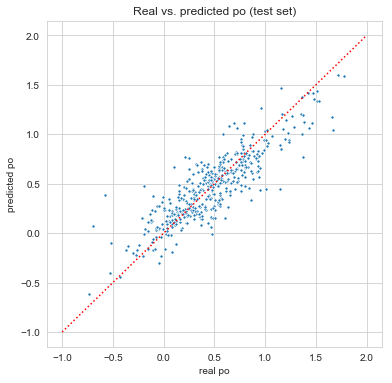

In [12]:
sns.set_style('whitegrid')
plt.figure(figsize=(6,6))
ax = sns.scatterplot(y_test, gcv2_gtbr_test_pred, s=10)
ax.set_xlabel("real po")
ax.set_ylabel("predicted po")
ax.set_title("Real vs. predicted po (test set)")
ax.plot([-1, 2], [-1, 2], color="red", linestyle=":")
plt.show()

## Influence of learning rate

In [15]:
sns.set_style('whitegrid')
def validationcurve_plot(title, param_range, train_scores_mean, train_scores_std, valid_scores_mean, valid_scores_std, ax):
    """Plots a validation curve and marks the best test score."""

    sns.lineplot(param_range, train_scores_mean, label="train", ax=ax)
    ax.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)

    sns.lineplot(param_range, valid_scores_mean, label="validation", ax=ax)
    ax.fill_between(param_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.2)

    ax.set_title(title)
    ax.set_xlabel("n_estimators")

    best_idx = valid_scores_mean.values.argmin()
    ax.scatter(param_range[best_idx], valid_scores_mean[best_idx], marker='x', c='red', zorder=10, label="best")

    ax.legend()

In [16]:
# this is just for the charts
preprocessor = make_column_transformer(
    (OneHotEncoder(dtype=np.float64), categorical_idxs),
    remainder = "passthrough"
)
gtbr = make_pipeline(preprocessor, GradientBoostingRegressor(random_state=0))

param_range = np.append(np.linspace(10, 90, 9, dtype=int), np.linspace(100, 800, 8, dtype=int))
low_learning_rate = 0.08
high_learning_rate = 0.12
parameters3 = { "gradientboostingregressor__learning_rate": [low_learning_rate],
                "gradientboostingregressor__n_estimators": param_range,
                "gradientboostingregressor__max_depth": [best_max_depth],
                "gradientboostingregressor__min_samples_split": [best_min_samples_split] }
gcv3_gtbr = GridSearchCV(gtbr, parameters3, scoring = "neg_mean_absolute_error", cv = 5, n_jobs=12, return_train_score=True)
gcv3_gtbr.fit(X_train, y_train)
df_gcv3_gtbr = pd.DataFrame(gcv3_gtbr.cv_results_)

parameters4 = { "gradientboostingregressor__learning_rate": [high_learning_rate],
                "gradientboostingregressor__n_estimators": param_range,
                "gradientboostingregressor__max_depth": [best_max_depth],
                "gradientboostingregressor__min_samples_split": [best_min_samples_split] }
gcv4_gtbr = GridSearchCV(gtbr, parameters4, scoring = "neg_mean_absolute_error", cv = 5, n_jobs=12, return_train_score=True)
gcv4_gtbr.fit(X_train, y_train)
df_gcv4_gtbr = pd.DataFrame(gcv4_gtbr.cv_results_)

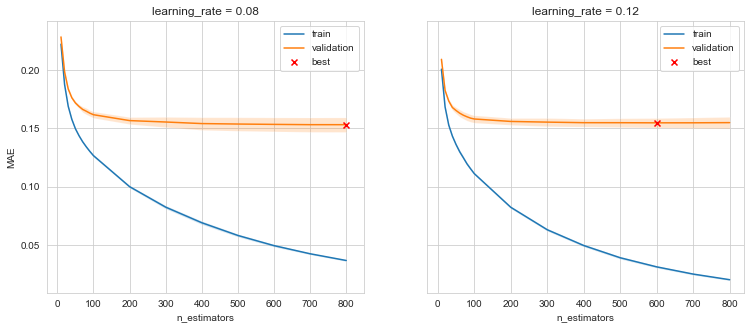

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 5), sharey=True)
validationcurve_plot("learning_rate = 0.08", param_range, -df_gcv3_gtbr["mean_train_score"], -df_gcv3_gtbr["std_train_score"],
                     -df_gcv3_gtbr["mean_test_score"], -df_gcv3_gtbr["std_test_score"], ax=ax1)
ax1.set_ylabel("MAE")
validationcurve_plot("learning_rate = 0.12", param_range, -df_gcv4_gtbr["mean_train_score"], -df_gcv4_gtbr["std_train_score"],
                     -df_gcv4_gtbr["mean_test_score"], -df_gcv4_gtbr["std_test_score"], ax=ax2)

In [20]:
print("On test data:")
print("learning rate = 0.08: MAE={:.3f}".format(-gcv3_gtbr.score(X_test, y_test)))
print("learning rate = 0.12: MAE={:.3f}".format(-gcv4_gtbr.score(X_test, y_test)))

On test data:
learning rate = 0.08: MAE=0.151
learning rate = 0.12: MAE=0.155


# Feature importance

## Permutation feature importance
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#permutation-importance-with-multicollinear-or-correlated-features

In [21]:
preprocessor = make_column_transformer(
    (OneHotEncoder(dtype=np.float64), categorical_idxs),
    remainder = "passthrough"
)
# using best parameters from grid search above
gtbr = make_pipeline(preprocessor,
                     GradientBoostingRegressor(random_state=0, learning_rate=best_learning_rate, n_estimators=best_n_estimators,
                                               max_depth=best_max_depth, min_samples_split=best_min_samples_split))
gtbr.fit(X_train, y_train)
tree_importances = gtbr.named_steps["gradientboostingregressor"].feature_importances_
perm_importances = permutation_importance(gtbr, X_train, y_train, scoring='neg_mean_absolute_error',
                                          n_repeats=10, n_jobs=12, random_state=0)
gtbr_test_pred = gtbr.predict(X_test)
gtbr_test_mae = mean_absolute_error(y_test, gtbr_test_pred)
gtbr_test_r2 = r2_score(y_test, gtbr_test_pred)
print("On test data:")
print("Tuned GTBR MAE = {:.3f}".format(gtbr_test_mae))
print("Tuned GTBR R^2 = {:.3f}".format(gtbr_test_r2))
print("(as above)")

On test data:
Tuned GTBR MAE = 0.153
Tuned GTBR R^2 = 0.750
(as above)


In [22]:
perm_sorted_idx = (-perm_importances["importances_mean"]).argsort()
perm_importances_sorted = perm_importances["importances_mean"][perm_sorted_idx]
cols_sorted = df_train.drop(columns="po_value").columns[perm_sorted_idx]

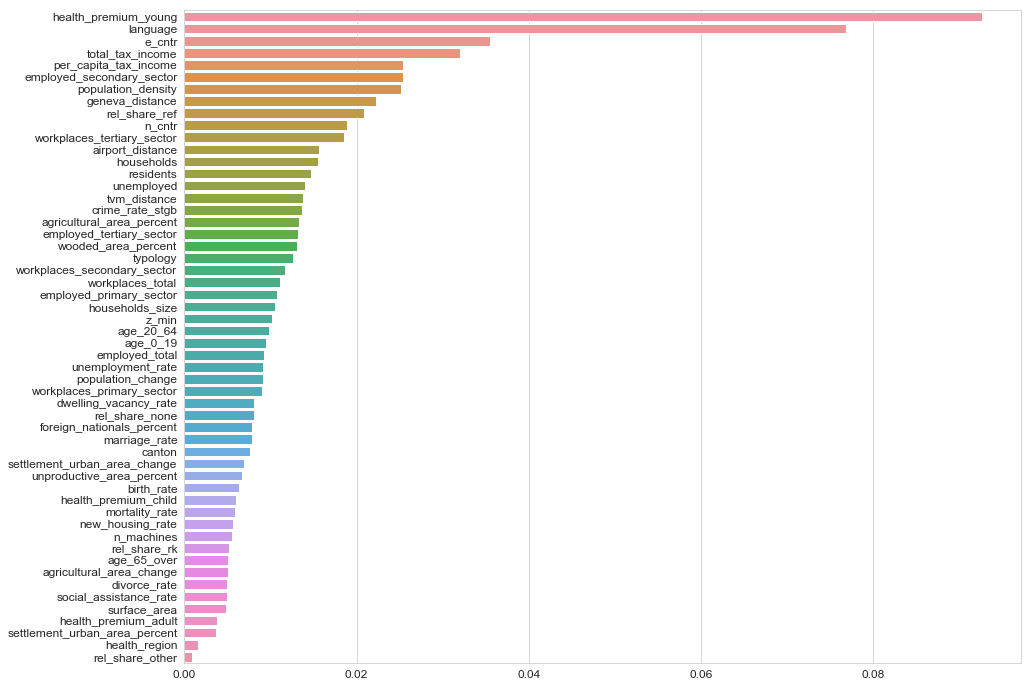

In [23]:
sns.set_style('whitegrid')
plt.figure(figsize = (15,12))
bp = sns.barplot(x=perm_importances_sorted, y=cols_sorted)
bp.tick_params(labelsize="large")

## Impurity-based feature importance

In [24]:
def get_column_names_of_one_hot_encoded_features(column_transformer, original_columns, categorical_features):
    ohe = column_transformer.named_transformers_["onehotencoder"]
    column_names = ohe.get_feature_names(categorical_features).tolist()
    for name in column_transformer.get_feature_names():
        if name.startswith("x"):
            column_names.append(original_columns[int(name[1:])])
    return np.array(column_names)

In [25]:
tree_sorted_idx = (-tree_importances).argsort()
tree_importances_sorted = tree_importances[tree_sorted_idx]
column_names = get_column_names_of_one_hot_encoded_features(gtbr.named_steps["columntransformer"],
                 df_train.drop(columns="po_value").columns, categorical_features)
tree_cols_sorted = column_names[tree_sorted_idx]

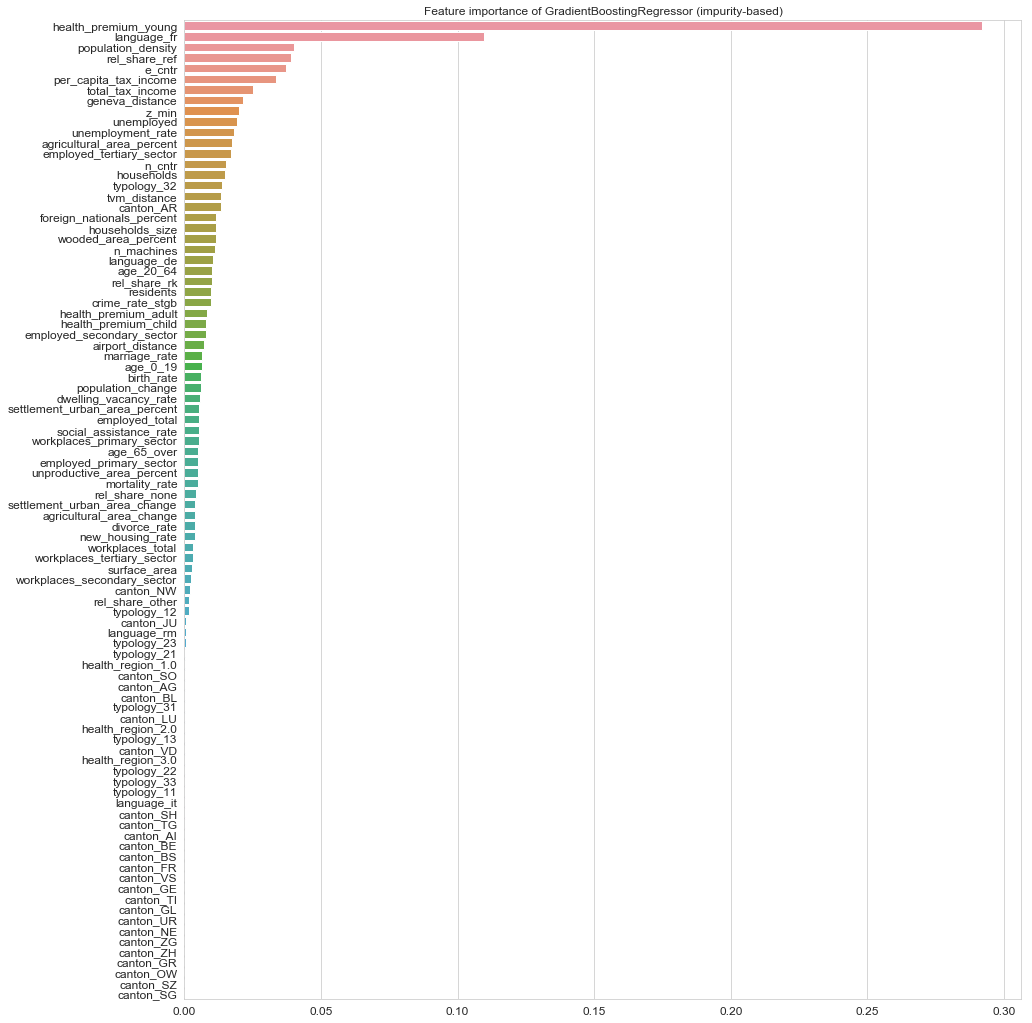

In [26]:
plt.figure(figsize = (15,18))
bp = sns.barplot(x=tree_importances_sorted, y=tree_cols_sorted)
bp.tick_params(labelsize="large")
bp.set_title("Feature importance of GradientBoostingRegressor (impurity-based)");

## With reduced features

In [77]:
reduced_features = [
    "health_premium_young",
    "language",
    "population_density",
    "rel_share_ref",
    "e_cntr",
    "n_cntr",
    "z_min",
    "per_capita_tax_income",
    "unemployment_rate",
    "agricultural_area_percent",
    "households",
    # "typology"
]

X_train_red = df_train[reduced_features].values
X_test_red = df_test[reduced_features].values

categorical_features_red = set(categorical_features).intersection(set(reduced_features))
categorical_idxs_red = cols_idxs(df[reduced_features], categorical_features_red)

In [78]:
preprocessor_red = make_column_transformer(
    (OneHotEncoder(dtype=np.float64), categorical_idxs_red),
    remainder = "passthrough"
)
# using best parameters from grid search above
gtbr_red = make_pipeline(preprocessor_red,
                         GradientBoostingRegressor(random_state=0, learning_rate=best_learning_rate, n_estimators=best_n_estimators,
                                                   max_depth=best_max_depth, min_samples_split=best_min_samples_split))
gtbr_red.fit(X_train_red, y_train)
perm_importances_red = permutation_importance(gtbr_red, X_train_red, y_train, scoring='neg_mean_absolute_error',
                                         n_repeats=10, n_jobs=12, random_state=0)
gtbr_red_test_pred = gtbr_red.predict(X_test_red)
gtbr_red_test_mae = mean_absolute_error(y_test, gtbr_red_test_pred)
gtbr_red_test_r2 = r2_score(y_test, gtbr_red_test_pred)
print("On test data:")
print("GTBR (red.) MAE = {:.3f}".format(gtbr_red_test_mae))
print("GTBR (red.) R^2 = {:.3f}".format(gtbr_red_test_r2))
save_score("gtbr_red", gtbr_red_test_mae, gtbr_red_test_r2, os.path.join("data", "results", "model_scores.csv"))

On test data:
Tuned GTBR (red.) MAE = 0.160
Tuned GTBR (red.) R^2 = 0.735


Similar to linear regression, reducing the number of features from 54 to 11 results in a model that is not much worse than the full-feature model.

| &nbsp; | full | red. |
| --- | --- | --- |
|MAE|0.153|0.160|
|$R^2$|0.750|0.735|

In [79]:
perm_sorted_idx_red = (-perm_importances_red["importances_mean"]).argsort()
perm_importances_sorted_red = perm_importances_red["importances_mean"][perm_sorted_idx_red]
cols_sorted_red = df_train[reduced_features].columns[perm_sorted_idx_red]

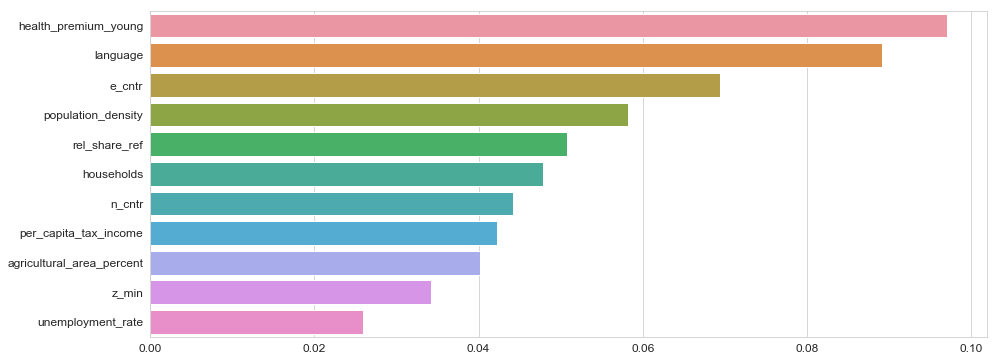

In [80]:
plt.figure(figsize = (15,6))
bp_red = sns.barplot(x=perm_importances_sorted_red, y=cols_sorted_red)
bp_red.tick_params(labelsize="large")